In [2]:
from google.colab import drive # loads a library to mount your google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings("ignore")
# import system libs
import os
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


In [4]:
train_data_dir = '/content/drive/MyDrive/final_data/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# print(labels)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

filepaths      labels
0     /content/drive/MyDrive/final_data/Training/men...  meningioma
1     /content/drive/MyDrive/final_data/Training/men...  meningioma
2     /content/drive/MyDrive/final_data/Training/men...  meningioma
3     /content/drive/MyDrive/final_data/Training/men...  meningioma
4     /content/drive/MyDrive/final_data/Training/men...  meningioma
...                                                 ...         ...
5707  /content/drive/MyDrive/final_data/Training/not...     notumor
5708  /content/drive/MyDrive/final_data/Training/not...     notumor
5709  /content/drive/MyDrive/final_data/Training/not...     notumor
5710  /content/drive/MyDrive/final_data/Training/not...     notumor
5711  /content/drive/MyDrive/final_data/Training/not...     notumor

[5712 rows x 2 columns]

In [5]:
test_data_dir = '/content/drive/MyDrive/final_data/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)
ts_df

filepaths     labels
0     /content/drive/MyDrive/final_data/Testing/pitu...  pituitary
1     /content/drive/MyDrive/final_data/Testing/pitu...  pituitary
2     /content/drive/MyDrive/final_data/Testing/pitu...  pituitary
3     /content/drive/MyDrive/final_data/Testing/pitu...  pituitary
4     /content/drive/MyDrive/final_data/Testing/pitu...  pituitary
...                                                 ...        ...
1306  /content/drive/MyDrive/final_data/Testing/glio...     glioma
1307  /content/drive/MyDrive/final_data/Testing/glio...     glioma
1308  /content/drive/MyDrive/final_data/Testing/glio...     glioma
1309  /content/drive/MyDrive/final_data/Testing/glio...     glioma
1310  /content/drive/MyDrive/final_data/Testing/glio...     glioma

[1311 rows x 2 columns]

In [6]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [7]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


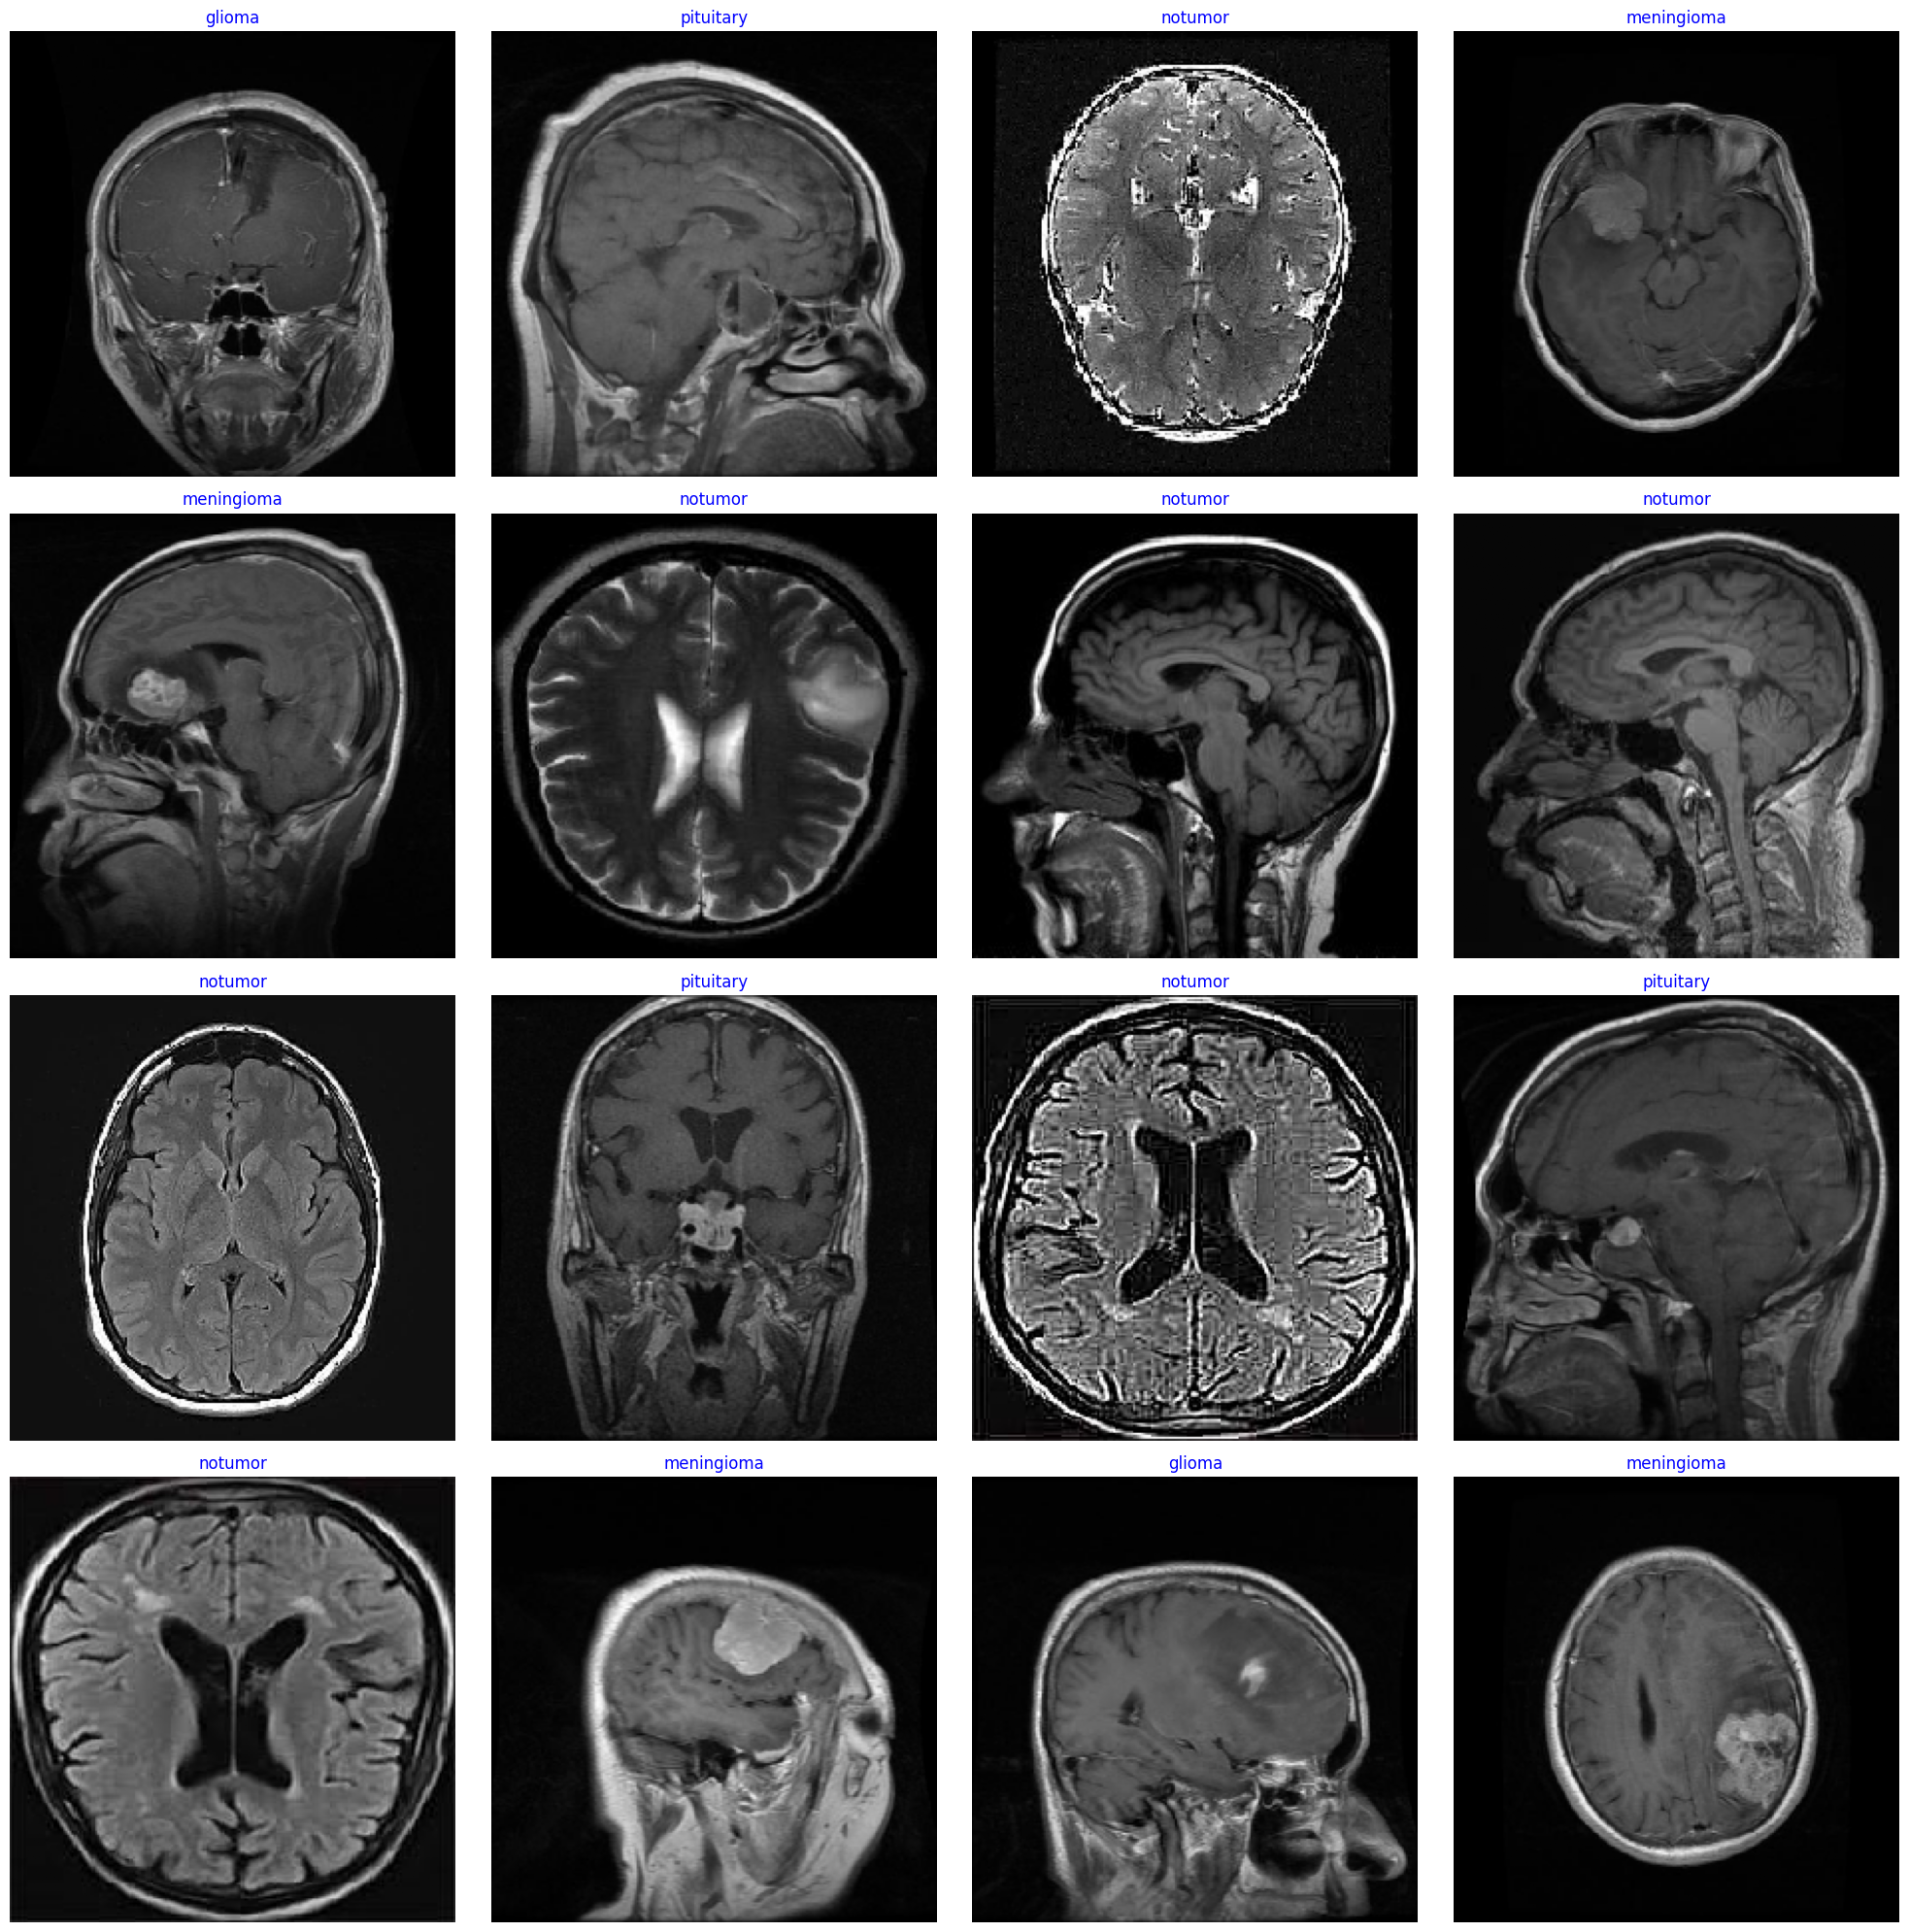

In [8]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [10]:
epochs = 30
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/30
357/357 [==============================] - 1592s 4s/step - loss: 4.1896 - accuracy: 0.5767 - val_loss: 0.6407 - val_accuracy: 0.6977
Epoch 2/30
357/357 [==============================] - 81s 227ms/step - loss: 0.4650 - accuracy: 0.8232 - val_loss: 0.5323 - val_accuracy: 0.8244
Epoch 3/30
357/357 [==============================] - 80s 224ms/step - loss: 0.3205 - accuracy: 0.8815 - val_loss: 0.3832 - val_accuracy: 0.8672
Epoch 4/30
357/357 [==============================] - 80s 223ms/step - loss: 0.2415 - accuracy: 0.9177 - val_loss: 0.3187 - val_accuracy: 0.8763
Epoch 5/30
357/357 [==============================] - 80s 223ms/step - loss: 0.1930 - accuracy: 0.9312 - val_loss: 0.2320 - val_accuracy: 0.9176
Epoch 6/30
357/357 [==============================] - 80s 223ms/step - loss: 0.1602 - accuracy: 0.9438 - val_loss: 0.1618 - val_accuracy: 0.9374
Epoch 7/30
357/357 [==============================] - 81s 226ms/step - loss: 0.1203 - accuracy: 0.9573 - val_loss: 0.1466 - val_acc

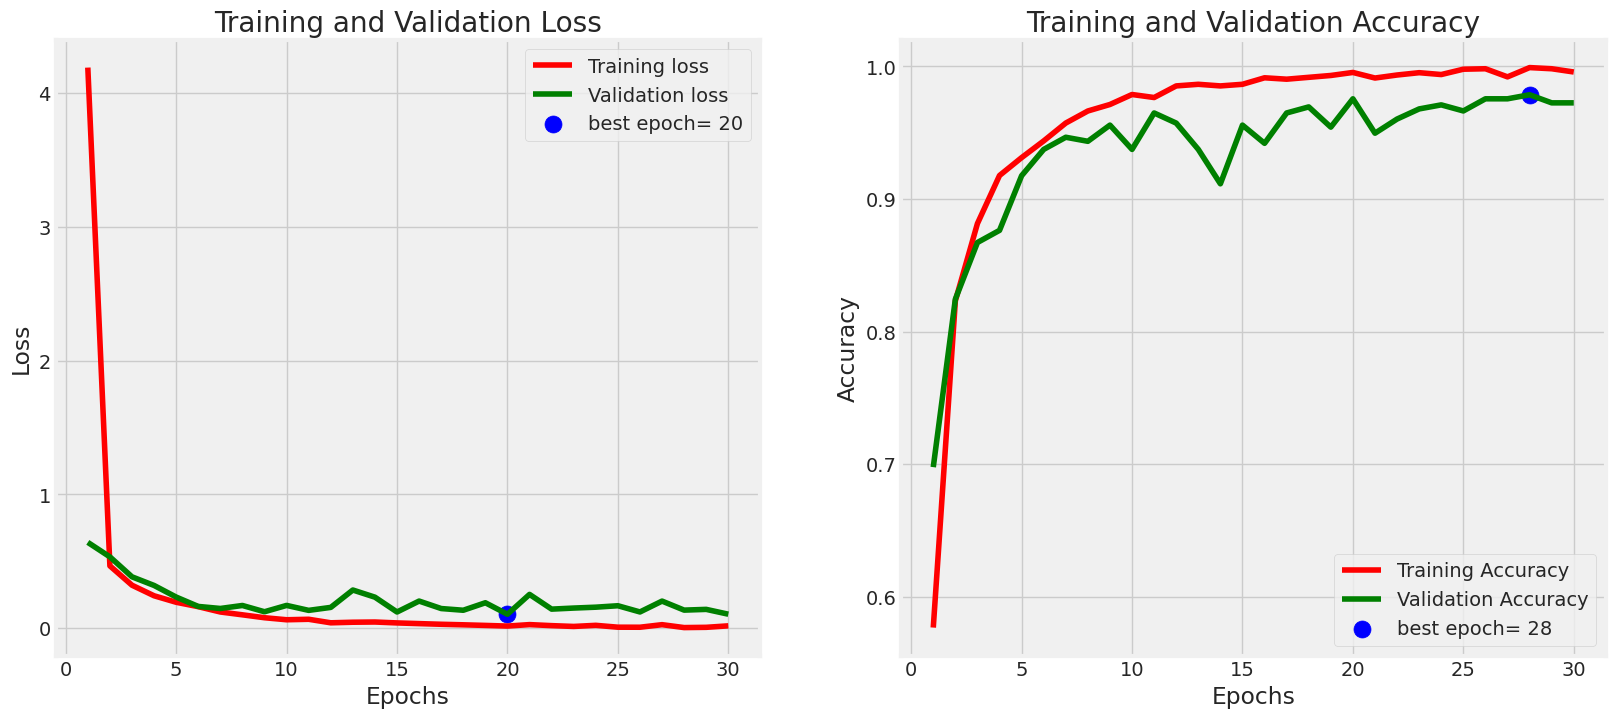

In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)


41/41 [==============================] - 206s 5s/step - loss: 0.1575 - accuracy: 0.9680


In [13]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)


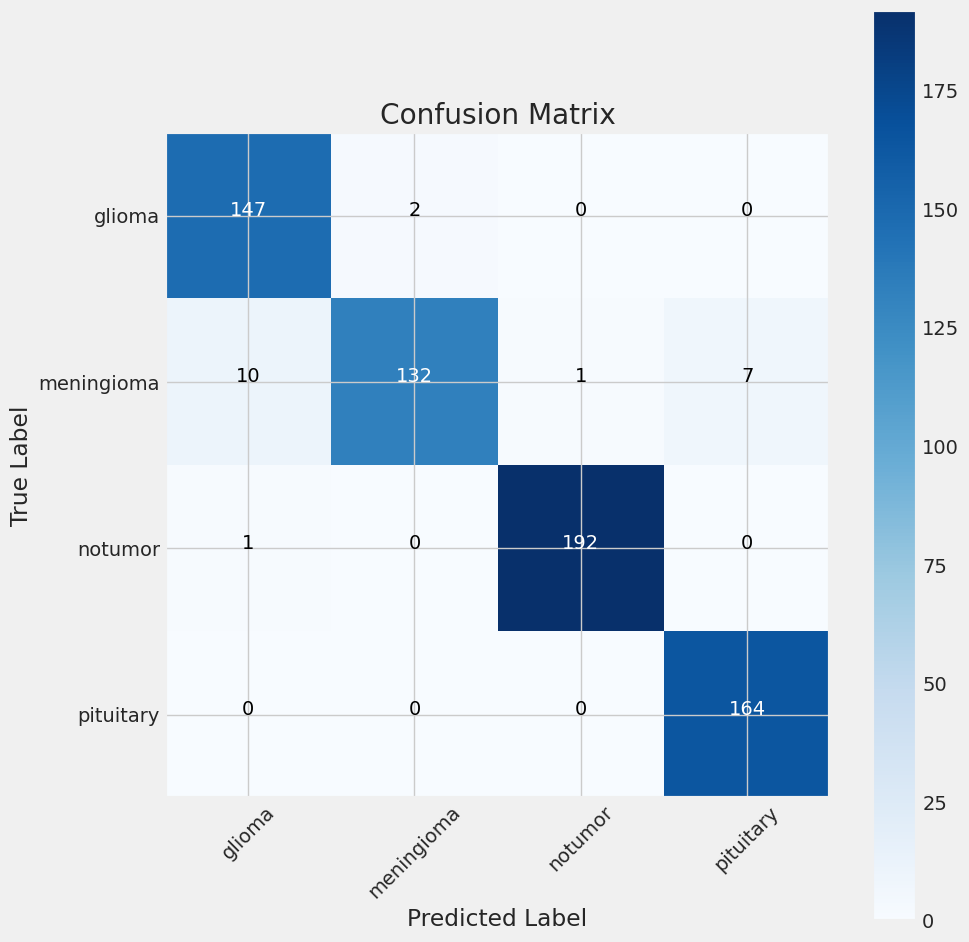

In [15]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.93      0.99      0.96       149
  meningioma       0.99      0.88      0.93       150
     notumor       0.99      0.99      0.99       193
   pituitary       0.96      1.00      0.98       164

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [17]:
from tensorflow.keras.preprocessing.image import array_to_img

1/1 [==============================] - 0s 22ms/step
Image 1: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0226.jpg - predicted label 1, actual label 0


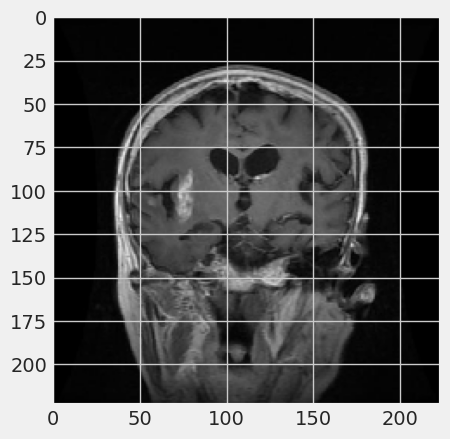

Image 2: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0025.jpg - predicted label 0, actual label 2


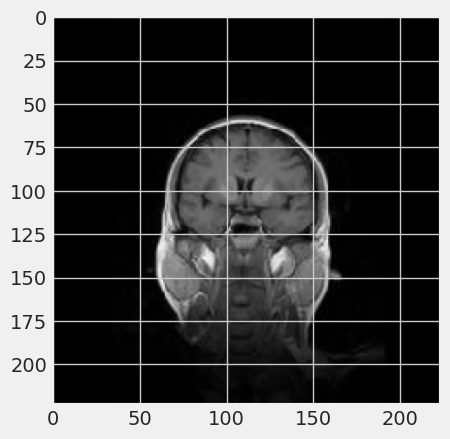

Image 3: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0226.jpg - predicted label 3, actual label 1


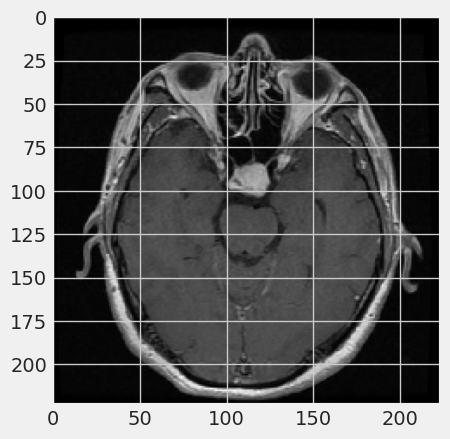

Image 4: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0074.jpg - predicted label 1, actual label 0


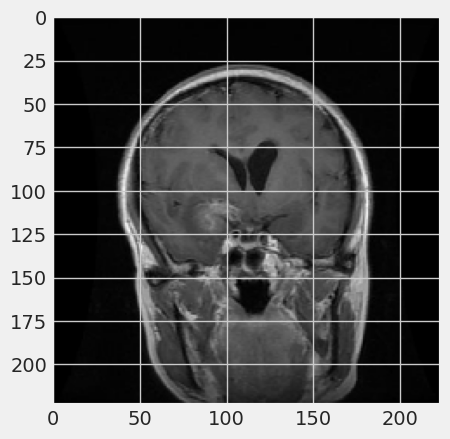

Image 5: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0097.jpg - predicted label 3, actual label 1


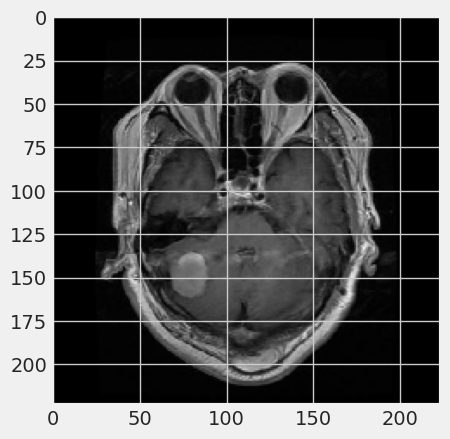

Image 6: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0097.jpg - predicted label 0, actual label 1


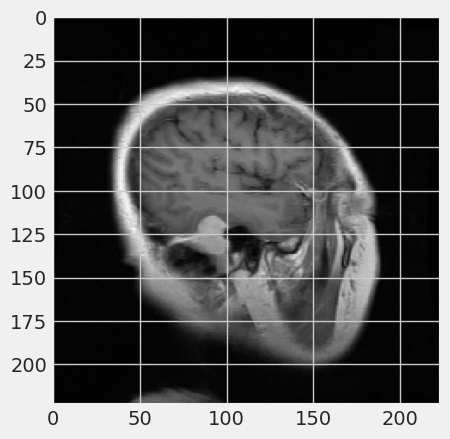

Image 7: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0025.jpg - predicted label 0, actual label 1


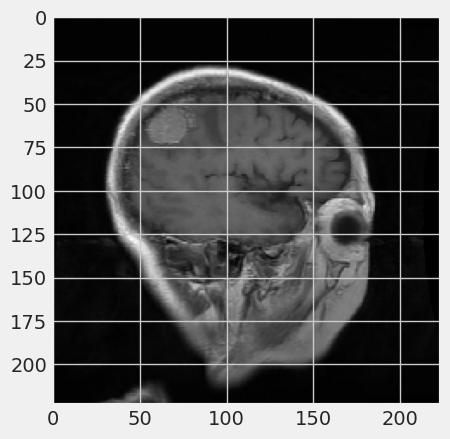

Image 8: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0338.jpg - predicted label 0, actual label 1


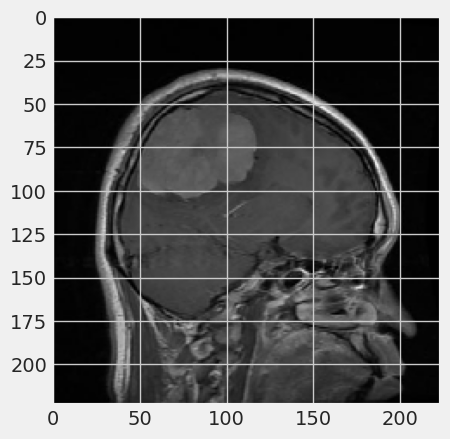

Image 9: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0027.jpg - predicted label 3, actual label 1


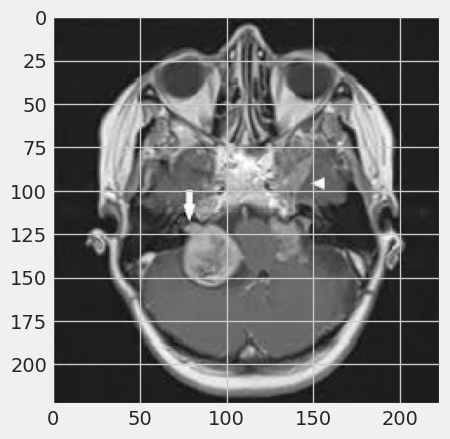

Image 10: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0240.jpg - predicted label 0, actual label 1


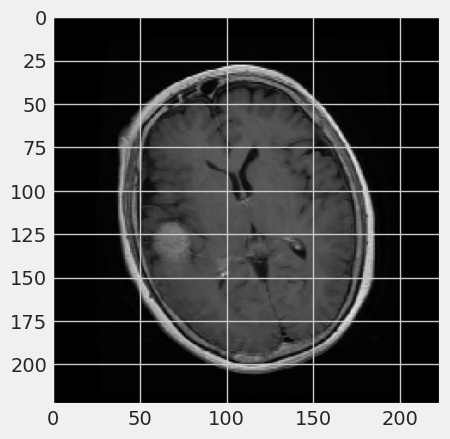

Image 11: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0209.jpg - predicted label 0, actual label 1


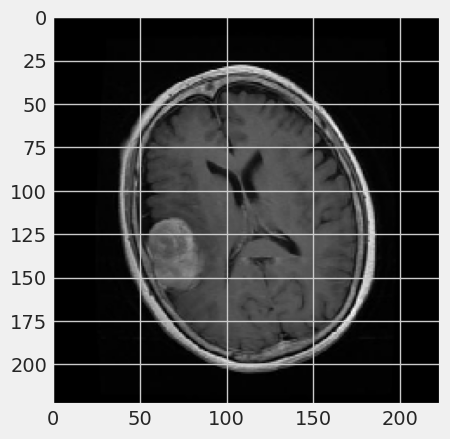

Image 12: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0074.jpg - predicted label 3, actual label 1


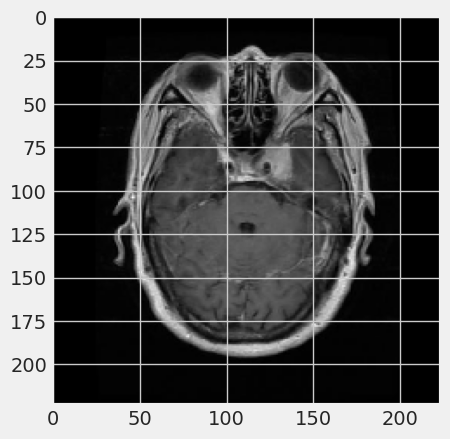

Image 13: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0097.jpg - predicted label 0, actual label 1


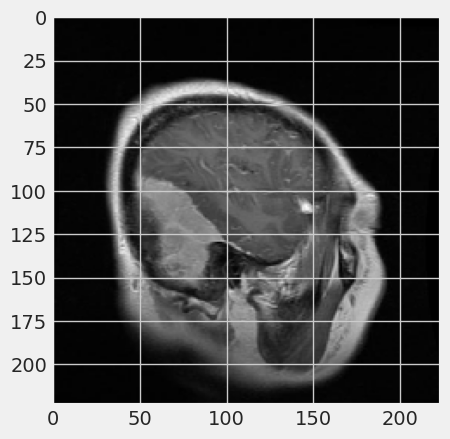

Image 14: /content/drive/MyDrive/final_data/Testing/pituitary/Te-pi_0053.jpg - predicted label 2, actual label 1


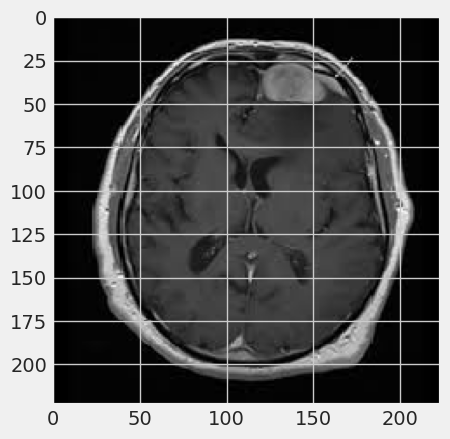

Image 15: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0338.jpg - predicted label 3, actual label 1


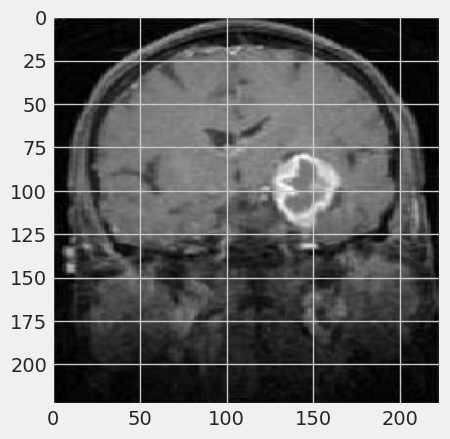

Image 16: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0025.jpg - predicted label 0, actual label 1


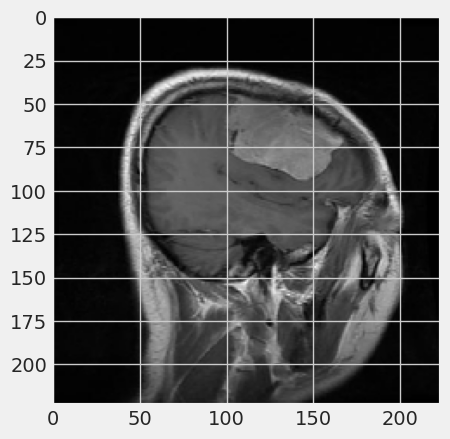

Image 17: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0209.jpg - predicted label 0, actual label 1


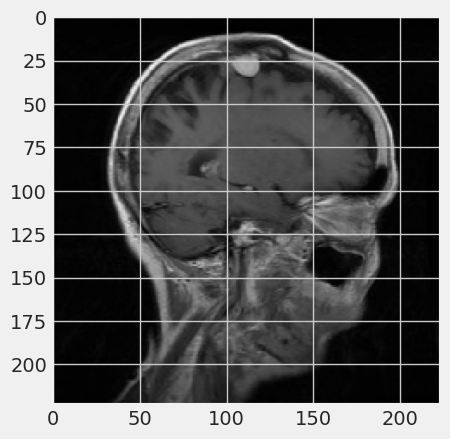

Image 18: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0241.jpg - predicted label 0, actual label 1


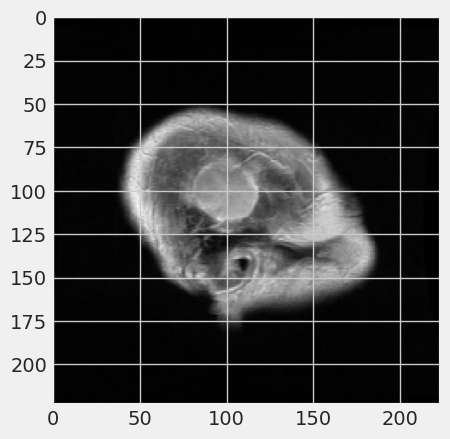

Image 19: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0097.jpg - predicted label 3, actual label 1


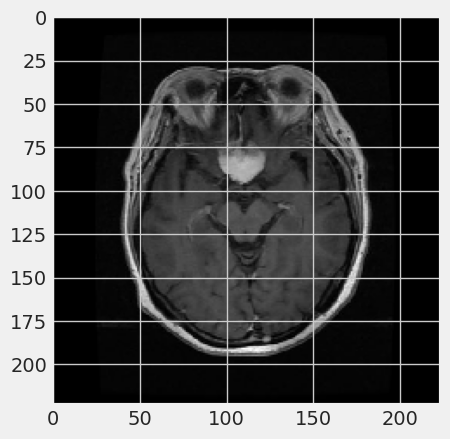

Image 20: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0209.jpg - predicted label 3, actual label 1


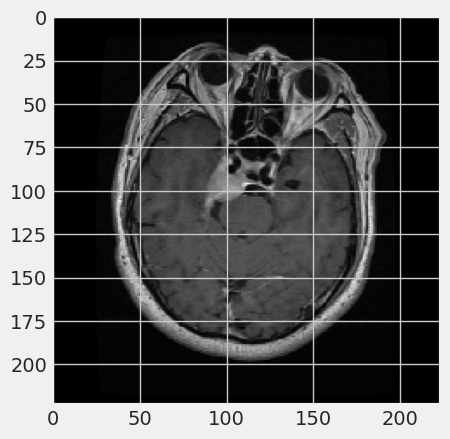

Image 21: /content/drive/MyDrive/final_data/Testing/notumor/Te-no_0376.jpg - predicted label 0, actual label 1


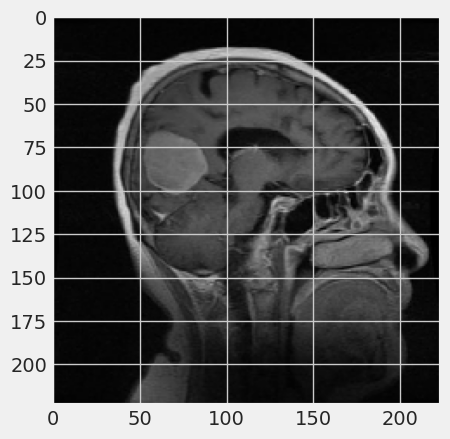

In [18]:
# Arrays to store misclassified images, predicted labels, and actual labels
misclassified_images = []
predicted_labels = []
actual_labels = []
image_names = []

# Loop over the test set
for images_batch, labels_batch in test_gen:
    # Make predictions for the current batch of images
    predictions_batch = model.predict(images_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)

    # Get the actual labels
    actual_labels_batch = np.argmax(labels_batch, axis=1)
    image_names_batch = test_gen.filenames
    # Find the indices of the misclassified images
    misclassified_indices = np.where(predicted_labels_batch != actual_labels_batch)[0]

    # Store the misclassified images and their predicted and actual labels
    for i in misclassified_indices:
        misclassified_images.append(array_to_img(images_batch[i]))
        predicted_labels.append(predicted_labels_batch[i])
        actual_labels.append(actual_labels_batch[i])
        image_names.append(image_names_batch[i])

    # Stop the loop after one pass over the test set
    if test_gen.batch_index == 0:
        break

# Display the misclassified images with their predicted and actual labels
for i in range(len(misclassified_images)):
    print(f'Image {i+1}: {image_names[i]} - predicted label {predicted_labels[i]}, actual label {actual_labels[i]}')
    plt.imshow(misclassified_images[i])
    plt.show()

In [20]:
model.save('/content/drive/MyDrive/final_data/tumor_models/Final_CNN_Brain Tumor.h5')

In [22]:
import cv2

In [23]:
# Load the saved model
model = keras.models.load_model('/content/drive/MyDrive/final_data/tumor_models/Final_CNN_Brain Tumor.h5')

# Read the test image
img = cv2.imread('/content/drive/MyDrive/final_data/Testing/meningioma/Te-meTr_0001.jpg')

# Resize the image
img = cv2.resize(img, (224, 224))

# Add a batch dimension
img = np.expand_dims(img, axis=0)

# Make predictions on the test image
predictions = model.predict(img)

# Get the predicted class
predicted_label = np.argmax(predictions)
predicted_class=classes[predicted_label]

# Print the predicted class
print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 1s/step
Predicted class: meningioma
